In [261]:
import utils, json, umap, hdbscan, umap.plot
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from ast import literal_eval
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from transformers import pipeline

In [2]:
keywords = ["數據科學", "資料科學", "數據工程", "資料工程", "資料庫", "演算法",
            "機器學習", "人工智慧", "人工智能", "數據分析", "自然語言", "電腦視覺",
            "資料分析", "商業分析", "產品分析", "data science",
            "data engineering", "database", "algorithm", "machine learning",
            "artificial intelligence", "natural language", "computer vision",
            "data analysis", "business analysis", "product analysis"]

path = "data/20231217_job_name.csv"

In [6]:
data = pd.read_csv(path)

In [7]:
def get_embedding(x):
    x = utils.get_splited_list(x, 2000)
    result = [utils.get_openai_embedding(i) for i in x]
    result = [i for j in result for i in j]
    result = [i.embedding for i in result]
    return result

In [10]:
embeddings = get_embedding(data.job_name.tolist())

In [11]:
job_name_classifier = CatBoostClassifier()
job_name_classifier.load_model("20231119_job_type_classifier")
job_name_classes = job_name_classifier.predict(embeddings).astype(bool)

In [17]:
dsa_job = data.\
    assign(embedding = embeddings,
           contain_keyword = lambda x: x.job_name.str.contains("|".join(keywords)),
           pred_contain_keyword = job_name_classes,
           months = lambda x: x.dates.apply(literal_eval)).\
    query("contain_keyword == True or pred_contain_keyword == True").\
    reset_index(drop = True).\
    filter(["id", "job_name", "embedding", "months", "times"])

In [242]:
monthly_count = dsa_job.\
    filter(["id", "months"]).\
    assign(times = lambda x: len(x.months)).\
    explode("months").\
    assign(month = lambda x: pd.to_datetime(x.months).dt.strftime("%Y-%m-01")).\
    groupby("month", as_index = False).\
    agg(count = ("id", "count"))

In [243]:
monthly_count["new"] = dsa_job.\
    filter(["id", "months"]).\
    assign(times = lambda x: len(x.months)).\
    explode("months").\
    groupby("id", as_index = False).\
    agg(month = ("months", "min")).\
    groupby("month", as_index = False).\
    agg(new = ("id", "count"))["new"]

In [245]:
monthly_count = monthly_count.\
    query("month >= '2023-02-01'")
monthly_count

,month,count,new
1,2023-02-01,956,956
2,2023-03-01,924,96
3,2023-04-01,951,126
4,2023-05-01,969,103
5,2023-06-01,955,82
6,2023-07-01,946,99
7,2023-08-01,928,118
8,2023-09-01,911,56
9,2023-10-01,894,84
10,2023-11-01,890,79


In [254]:
print("{:.0f}".format(monthly_count["count"].mean()), "{:.0f}".format(monthly_count["new"][1:].mean()))

930 93


In [260]:
px.line(monthly_count,
        x = "month", y = "count", text = "count",
        markers = True, width = 800, height = 600,
        labels = dict(title="Legend Title"),
        title = "Monthly Taipei DSA Job Openings<br><sup>From Feb. to Dec. 2023, there is an average of 930 job openings each month,<br>with only 93 new positions added monthly in Taipei city, Taiwan.</sup>").\
    add_bar(x=monthly_count["month"][1:], y=monthly_count["new"][1:], text = monthly_count["new"][1:], name="New Vacancies").\
    update_layout(template="plotly_white", hovermode="x unified").\
    update_xaxes(title="Month").\
    update_yaxes(title="Job Vacancies", tickformat=",")

In [221]:
reduced_embeddings = umap.UMAP(n_neighbors=50).fit(np.array(dsa_job.embedding.tolist()))

In [222]:
labels = hdbscan.HDBSCAN(min_cluster_size = 50).fit_predict(reduced_embeddings.embedding_)

<Axes: >

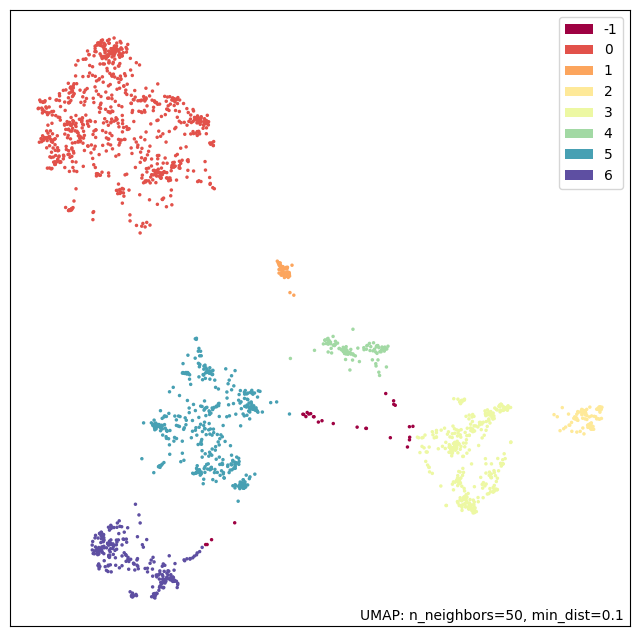

In [223]:
umap.plot.points(reduced_embeddings, labels = labels)

In [224]:
dsa_job["type"] = labels

In [225]:
dsa_job.groupby("type", as_index = False).agg(count = ("id", "count"), text = ("job_name", lambda x: [x]))

,type,count,text
0,-1,28,"[[ai/python engineer(圖像辨識/數據分析), it/ai 數據分析工程師..."
1,0,785,"[[s.電子商務‧資料科學分析師, 資料科學分析師(總公司), hy- 美商知名日用品公司【..."
2,1,53,"[[東南亞金融科技發展-數據工程師（數數發中心, ddt）, 資料科學工程師 （data s..."
3,2,84,"[[sports data scientist (tensorflow, keras), s..."
4,3,329,"[[computer vision engineer-camera system, seni..."
5,4,106,"[[資料科學家/工程師, 科技金融_ai數據科學家, 資料科學家 (data scienti..."
6,5,403,"[[data engineer 數據工程師(台北總公司), 【採線上面談】senior da..."
7,6,252,[[資深資料庫管理師 / senior database administrator (db...


In [262]:
zsclassifier = pipeline(model="facebook/bart-large-mnli")

https://www.bhef.com/publications/quant-crunch-how-demand-data-science-skills-disrupting-job-market

In [236]:
job_category = [
    "Data Scientists & Advanced Analytics: Create sophisticated analytical models used to build new datasets and derive new insights from data",
    "Data Analysts: Leverage data analysis and modeling techniques to solve problems and glean insight across functional domains",
    "Data Systems Developers: Design, build and maintain and organization's data and analvtical infrastructure",
    "Analytics Managers: Oversee analvtical operations and communicate insights to executives",
    "Functional Analysts: Utilize data and analytical models to inform specific functions and business decisions",
    "Data-Driven Decision Makers: Leverage data to inform strategic and operational decisions"
    ]

In [265]:
job_categories = zsclassifier(dsa_job["job_name"].to_list(), candidate_labels = job_category)